In [309]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mat_patches
import cv2
from PIL import Image
from tqdm.notebook import tqdm

In [224]:
def show(img, ax=None, patches=None, lines=None, color='r'):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    #plt.imshow(img, cmap='gray')
    if patches:
        for ((x1,y1),(w,h)) in patches:
            rect = mat_patches.Rectangle((x1,y1), w, h, linewidth=1, edgecolor=color, facecolor='none')
            ax.add_patch(rect)
    if lines:
        for (x1,y1,x2,y2) in lines:
            ax.axline((x1,y1), (x2,y2), c=color)
            
    # plt.figure(figsize=(12, 8))
    ax.imshow(img, cmap='gray');

In [225]:
def cmyk_to_luminance(c, m, y, k):
    c = c * (1 - k) + k
    m = m * (1 - k) + k
    y = y * (1 - k) + k

    r, g, b = (1 - c), (1 - m), (1 - y)
    y = 0.299 * r + 0.587 * g + 0.114 * b
    return y

def convert_to_grayscale(img):
    gray = np.zeros((img.shape[0], img.shape[1]))
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            c, m, y, k = img[i, j]
            gray[i, j] = cmyk_to_luminance(c, m, y, k)
    gray /= np.max(gray)
    return gray

(222, 602, 3)


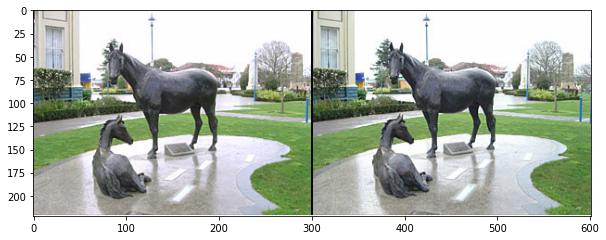

In [226]:
#left_img = plt.imread('data/stereo-corridor_l.gif')
#right_img = plt.imread('data/stereo-corridor_r.gif')
#left_img = convert_to_grayscale(left_img)
#right_img = convert_to_grayscale(right_img)


stereo_pair = plt.imread('data/stereo-cambridge.jpg')
show(stereo_pair)
print(stereo_pair.shape)
mid_x = stereo_pair.shape[1] // 2
left_img = stereo_pair[:, :mid_x]
right_img = stereo_pair[:, mid_x:]

left_img = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)
right_img = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)


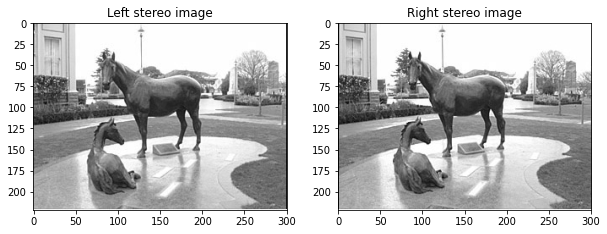

In [227]:
fig, axs = plt.subplots(1,2, figsize=(10, 8))
axs[0].set_title('Left stereo image')
axs[1].set_title('Right stereo image')
show(left_img, ax=axs[0])
show(right_img, ax=axs[1])

In [228]:
def get_patch(img, patch_loc, patch_size):
    x, y = patch_loc[0], patch_loc[1]
    w, h = patch_size[0], patch_size[1]
    patch = img[y:y+h, x:x+w]
    return patch

def show_patch(patch):
    plt.imshow(patch, cmap='gray')

In [229]:
def get_strip(img, patch_loc, patch_size):
    x, y = patch_loc[0], patch_loc[1]
    w, h = patch_size[0], patch_size[1]
    strip = img[y:y+h, :-w]
    return strip

def show_strip(strip):
    plt.figure(figsize=(15, 10))
    plt.imshow(strip, cmap='gray')

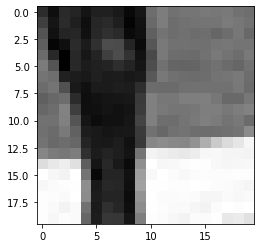

In [230]:
patch_loc = [125, 125]
patch_size = [20,20]

patch = get_patch(left_img, patch_loc, patch_size)
show_patch(patch)

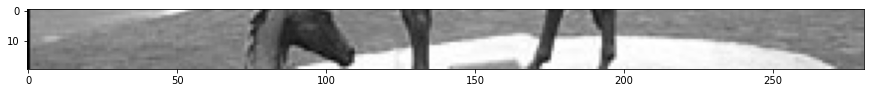

In [231]:
strip = get_strip(right_img, patch_loc, patch_size)
show_strip(strip)

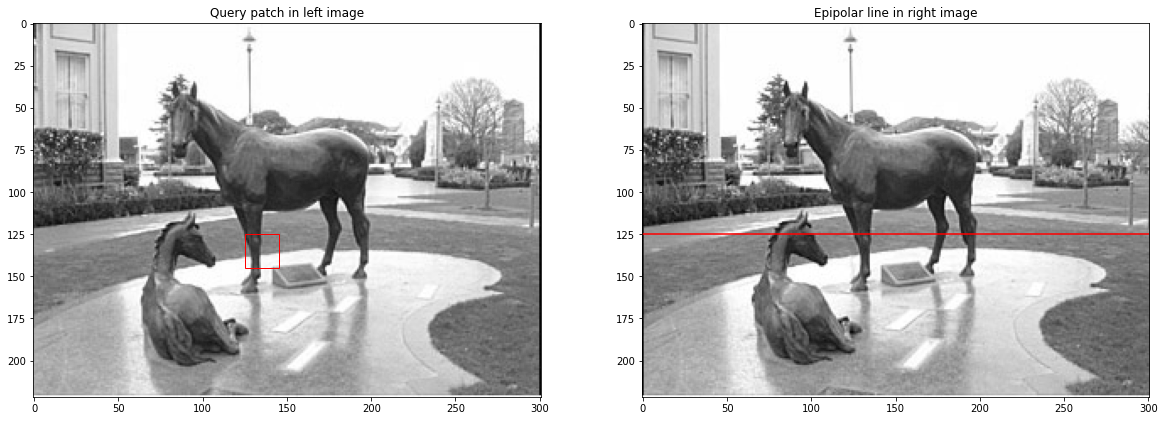

In [232]:
fig, axs = plt.subplots(1,2, figsize=(20, 8))
axs[0].set_title('Query patch in left image')
axs[1].set_title('Epipolar line in right image')
show(left_img, ax=axs[0], patches=[(patch_loc, patch_size),])
show(right_img, ax=axs[1], lines=[(patch_loc[0], patch_loc[1], strip.shape[1], patch_loc[1])])

In [233]:
def find_best_match(patch, strip):
    """Find best patch in strip and return x value of top-right corner"""
    best_x = 1
    best_ssd = 1000000
    patch_w = patch.shape[1]
    strip_w = strip.shape[1]
    ssds = []
    for x in range(patch_w, strip_w - patch_w - 1):
        candidate_patch = strip[:, x:x+patch_w]
        ssd = np.sum((patch - candidate_patch)**2)
        if ssd < best_ssd:
            best_x = x
            best_ssd = ssd
        ssds.append(ssd)
            
    return best_x, best_ssd, ssds

def correlation_coefficient(patch1, patch2):
    product = np.mean((patch1 - patch1.mean()) * (patch2 - patch2.mean()))
    stds = patch1.std() * patch2.std()
    if stds == 0:
        return 0
    else:
        product /= stds
        return product

def find_best_match_correlation(patch, strip):
    """Find best patch in strip and return x value of top-right corner"""
    best_x = 1
    best_c = 0
    patch_w = patch.shape[1]
    strip_w = strip.shape[1]
    cs = []
   
    for x in range(patch_w, strip_w - patch_w - 1):
        candidate_patch = strip[:, x:x+patch_w]
        #b = candidate_patch.ravel()
        #b = (b - np.mean(b)) / (np.std(b))
        #c = np.sum(np.correlate(a, b, 'full'))
        c = correlation_coefficient(patch, candidate_patch)
        
        if c > best_c:
            best_x = x
            best_c = c
        cs.append(c)
    return best_x, best_c, cs


Using Sum of Squared differences (SSD), lower is better:

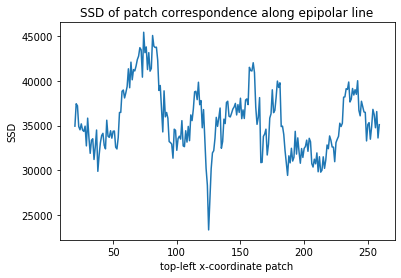

In [234]:
best_x, best_ssd, ssds = find_best_match(patch, strip)
plt.plot([i for i in range(patch.shape[1], patch.shape[1]+len(ssds))], ssds);
plt.title('SSD of patch correspondence along epipolar line');
plt.ylabel('SSD');
plt.xlabel('top-left x-coordinate patch');

Using Normalized Cross-Correlation, higher is better:

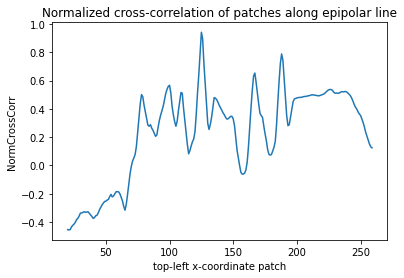

In [235]:
best_x, best_ssd, ssds = find_best_match_correlation(patch, strip)
plt.plot([i for i in range(patch.shape[1], patch.shape[1]+len(ssds))], ssds);
plt.title('Normalized cross-correlation of patches along epipolar line');
plt.ylabel('NormCrossCorr');
plt.xlabel('top-left x-coordinate patch');

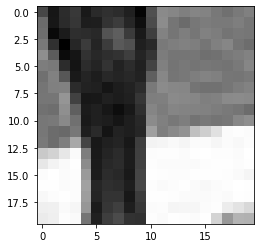

In [236]:
best_match_loc = [best_x, patch_loc[1]]
best_match_size = patch_size
best_match_patch = get_patch(right_img, best_match_loc, best_match_size)
show_patch(best_match_patch)

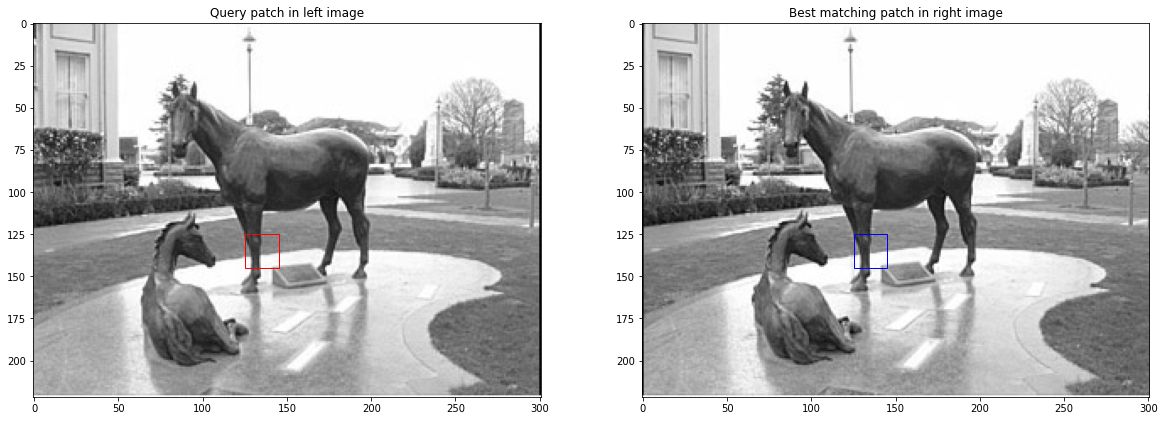

In [237]:
fig, axs = plt.subplots(1,2, figsize=(20, 8))
axs[0].set_title('Query patch in left image')
axs[1].set_title('Best matching patch in right image')
show(left_img, ax=axs[0], patches=[(patch_loc, patch_size),])
show(right_img, ax=axs[1], patches=[(best_match_loc, best_match_size)], color='b')

## Creating disparity map

In [256]:
def disparity_map(left_img, right_img, patch_size, stride=3, correlation=False):
    assert patch_size[0] == patch_size[1]  # Constraining to square patches
    #left_img = cv2.GaussianBlur(left_img,(5,5), 5, cv2.BORDER_DEFAULT)
    #right_img = cv2.GaussianBlur(right_img,(5,5), 5, cv2.BORDER_DEFAULT)
    size = patch_size[0]
    h, w = left_img.shape[0], left_img.shape[1]
    disparity_map = []
    for i in range(0, h - size - 1, stride):
        strip = get_strip(right_img, (i, 0), patch_size)
        disparity_row = []
        for j in range(0, w - size - 1, stride):
            patch = get_patch(left_img, (j,i), patch_size)
            if correlation:
                best_x, _, _ = find_best_match_correlation(patch, strip)
            else:
                best_x, _, _ = find_best_match(patch, strip)
            disparity = j - best_x
            disparity_row.append(disparity)
        disparity_map.append(disparity_row)
    disp_map = np.array(disparity_map)
    return disp_map
    

In [259]:
patch_size = [15, 15]
disp_map = disparity_map(left_img, right_img, patch_size, stride=2, correlation=True)
disp_map.shape

(103, 143)

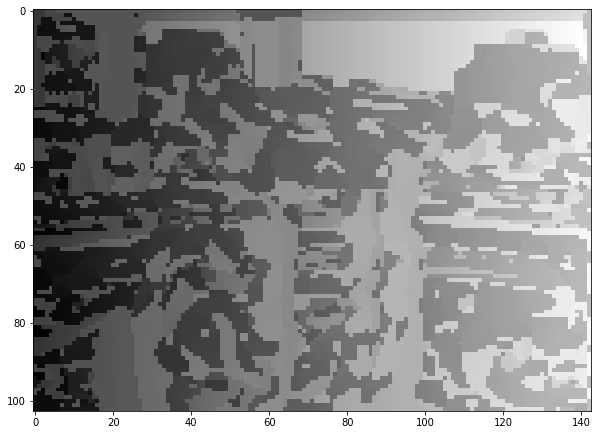

In [260]:
show(disp_map)

### Dynamic Programming approach to get disparity

In [344]:
def calc_optimal_match(left_img, right_img, occ_cost=0.0009):
    left_img = left_img / 255
    right_img = right_img / 255
    
    nrows = left_img.shape[0]
    ncols = left_img.shape[1]
    
    C = np.zeros((ncols, ncols))
    M = np.zeros_like(C)
    
    for row in tqdm(range(1, nrows)):
        for r in range(1, ncols):
            C[r, 0] = r * occ_cost
        
        for r in range(1, ncols):
            C[0, r] = r * occ_cost
        
        for i in range(1, ncols):
            for j in range(1, ncols):
                temp = (left_img[row, i] - right_img[row, j])**2

                min1 = C[i-1, j-1] + temp     # No occlusion
                min2 = C[i, j-1] + occ_cost   # Left occlusion
                min3 = C[i-1, j] + occ_cost   # Right occlusion

                cmin = np.min([min1, min2, min3])
                C[i, j] = cmin

                # Store info about which path was taken
                # To reconstruct optimal path later
                if cmin == min1:
                    M[i, j] = 1   # No occlusion
                elif cmin == min2:
                    M[i, j] = 2   # Left occlusion
                elif cmin == min3:
                    M[i, j] = 3   # Right occlusion
                    
                    
        i, j = ncols-1, ncols-1
        while i != 0 and j != 0:
            if M[i, j] == 1:
                displeft[row, i] = abs(i - j)  # Disparity image in left image coordinates
                dispright[row, j] = abs(j - i) # Disparity image in right image coordinates
                i -= 1
                j -= 1
            
            if M[i, j] == 2:
                displeft[row, i] = np.nan
                j -= 1
            
            elif M[i, j] == 3:
                dispright[row, j] = np.nan
                i -= 1
                
                
    return C, M, displeft, dispright
                

In [345]:
C, M, displeft, dispright = calc_optimal_match(left_img, right_img)

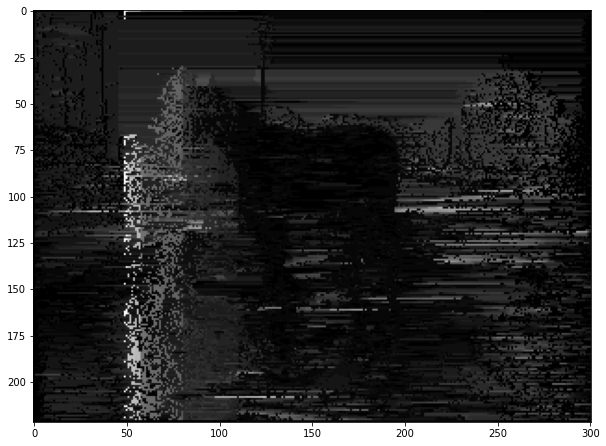

In [372]:
#dispright_norm = (dispright - np.mean(dispright)) / (np.max(dispright) - np.min(dispright))
show(dispright)

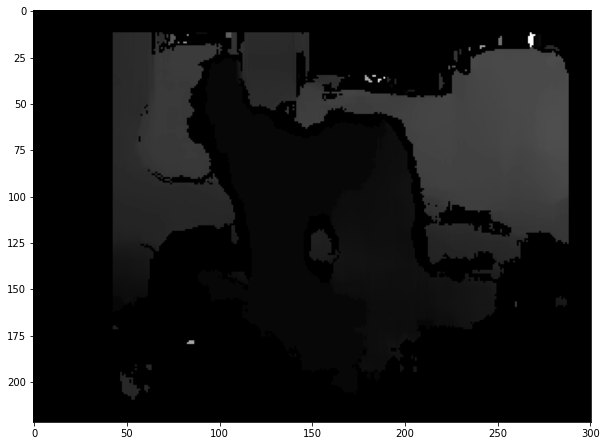

In [246]:
#gif = cv2.VideoCapture('data/stereo-cambridge_l.jpg')
#ret, imgL = gif.read() 
#imgL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)

#gif = cv2.VideoCapture('data/stereo-cambridge_r.jpg')
#ret, imgR = gif.read() 
#imgR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)

stereo = cv2.StereoBM_create(numDisparities=32, blockSize=25)
disparity = stereo.compute(left_img, right_img)
#plt.imshow(disparity,'gray')
show(disparity)